In [5]:
%load_ext autoreload
%autoreload 2

import os
import dosma as dm
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pickle

from dosma.scan_sequences import QDess
from dosma import ImageDataFormat

from utils.filter_qmaps import *
from utils.difference_map_tissue import *
from utils.apply_intensity_threshold import *
from utils.apply_volume_threshold import *
from utils.compute_t2 import *
from utils.convert_qdess_dicom2nii import *
from utils.sgd_based_registration import *
from utils.sgd_based_qmap_registration import *
from utils.dosma_segmentation import *
from utils.compute_DSC import *
from utils.compute_intensity_threshold import *
from utils.compute_volume_threshold import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define directory paths

In [3]:
os.environ['DIR']= '/dataNAS/people/anoopai/DESS_ACL_study/CA_code_for_Ananya'
os.environ['DATA']= '/dataNAS/people/anoopai/DESS_ACL_study/CA_code_for_Ananya/data'
os.environ['FILES']= '/dataNAS/people/anoopai/DESS_ACL_study/CA_code_for_Ananya/files'

# Change working directory to the directory containing data
dir_path = os.environ['DIR']
data_path = os.environ['DATA']
files_path = os.environ['FILES']

# Define file paths

In [14]:
baseline_qdess_path_dicom = os.path.join(data_path, 'Base_A1_dicom')
baseline_qdess_path= os.path.join(data_path, 'Base_A1')

followup_qdess_path_dicom = os.path.join(data_path, 'Follow_B1_dicom')
followup_qdess_path= os.path.join(data_path, 'Follow_B1')
followup_qdess_reg_path= os.path.join(data_path, 'Follow_B1_reg')

baseline_mask_path = os.path.join(data_path, 'Base_A1_seg_fc.nii')
followup_mask_path = os.path.join(data_path,'Follow_B1_seg_fc.nii')
followup_mask_reg_path = os.path.join(data_path, 'Follow_B1_seg_fc_reg.nii')

baseline_qmap_path = os.path.join(data_path, 'Base_A1_t2')
# followup_qmap_path = os.path.join(data_path, 'Follow_B1_t2')
followup_qmap_reg_path = os.path.join(data_path, 'Follow_B1_t2_reg')
baseline_t2_map_path = os.path.join(baseline_qmap_path, 'fc/t2/t2.nii.gz')
followup_t2_map_reg_path = os.path.join(followup_qmap_reg_path, 'fc/t2/t2.nii.gz')
baseline_t2_map_filt_path = os.path.join(baseline_qmap_path, 'fc/t2/t2_filt.nii.gz')
followup_t2_map_reg_filt_path = os.path.join(followup_qmap_reg_path, 'fc/t2/t2_filt.nii.gz')

baseline_qmap_b1corr_path = os.path.join(data_path, 'Base_A1_t2.nii')
followup_qmap_b1corr_path = os.path.join(data_path, 'Follow_B1_t2.nii')
followup_qmap_b1corr_reg_path = os.path.join(data_path, 'Follow_B1_t2_reg.nii')
baseline_t2_map_b1corr_filt_path = os.path.join(data_path, 'Base_A1_t2_filt.nii.gz')
followup_t2_map_b1corr_reg_filt_path = os.path.join(data_path, 'Follow_B1_t2_reg_filt.nii.gz')

# directory where elastix parameter/dosma segmentation model weights files are stored
elastix_file_path = os.path.join(files_path, 'elastic_parameters/elastix_registration_parameters_SDF_mask.txt')
dosma_seg_weights_path= os.path.join(files_path, 'weights/qDESS_2021_v1-rms-unet2d-pc_fc_tc_men_weights.h5')

difference_map_save_path= os.path.join(data_path, 'difference_map.nii.gz')
differene_maps_all_path = os.path.join(data_path, 'difference_maps_all.pkl')
diff_map_intensity_thresholded_save_path = os.path.join(data_path, 'difference_map_intensity_thresholded.nii.gz')
diff_map_intensity_thresholded_all_path = os.path.join(data_path, 'difference_maps_intensity_thresholded_all.pkl')
diff_map_volume_thresholded_save_path = os.path.join(data_path, 'difference_map_volume_thresholded.nii.gz')

# Step 1 : Data Preprocessing 

## A. Convert Qdess file format: dicoms to nii (usable by Dosma)

In [4]:
# baseline scans
convert_qdess_dicom2nii(baseline_qdess_path_dicom, baseline_qdess_path)

# followupscans
convert_qdess_dicom2nii(followup_qdess_path_dicom, followup_qdess_path)

Loading Qdess dicoms...


100%|██████████| 236/236 [00:00<00:00, 271.45it/s]


Saving Qdess as nifti...
Loading Qdess dicoms...


100%|██████████| 236/236 [00:00<00:00, 243.17it/s]


Saving Qdess as nifti...


## B. Register Follow-up scan to baseline scan

This code will run elastix on torino (in an interactive python file). If you are running a .py file or not on torino, the below code block is not needed

In [8]:
elastix_folder = '/dataNAS/people/anoopai/elastix'
os.environ['PATH'] = f"{elastix_folder}/bin:{os.environ['PATH']}"
if 'LD_LIBRARY_PATH' in os.environ:
    os.environ['LD_LIBRARY_PATH'] = f"{elastix_folder}/lib:{os.environ['LD_LIBRARY_PATH']}"
else:
    os.environ['LD_LIBRARY_PATH'] = f"{elastix_folder}/lib"

#!elastix --version
try:
    version_output = subprocess.check_output(['elastix', '--version'], stderr=subprocess.STDOUT, text=True)
    print("Elastix version information:")
    print(version_output)
except subprocess.CalledProcessError as e:
    print("Error running elastix --version:")
    print(e.output)

Elastix version information:
elastix version: 4.900



### Signed-distance based registration

Signed-distance field-based registration approach is applied to achieve consistent spatial alignment of femoral cartilage regions between visits within each subject. 
We first generated 3D signed-distance fields of femoral cartilage segmentation masks for each visit. This involves computing the distance of each voxel in the image from the femoral cartilage surface. The “sign” of this distance is positive for voxels outside the surface and negative for voxels inside the surface. We then clipped the signed-distance field map at +5 mm, to focus on data near or inside the cartilage surface. Next, we rigidly registered this signed-distance map from a moving visit to the fixed visit. Rigid registration was used because all registrations were within a subject. The transformation matrix fitted during the registration was then applied to align the moving qDESS scan to the fixed scan.

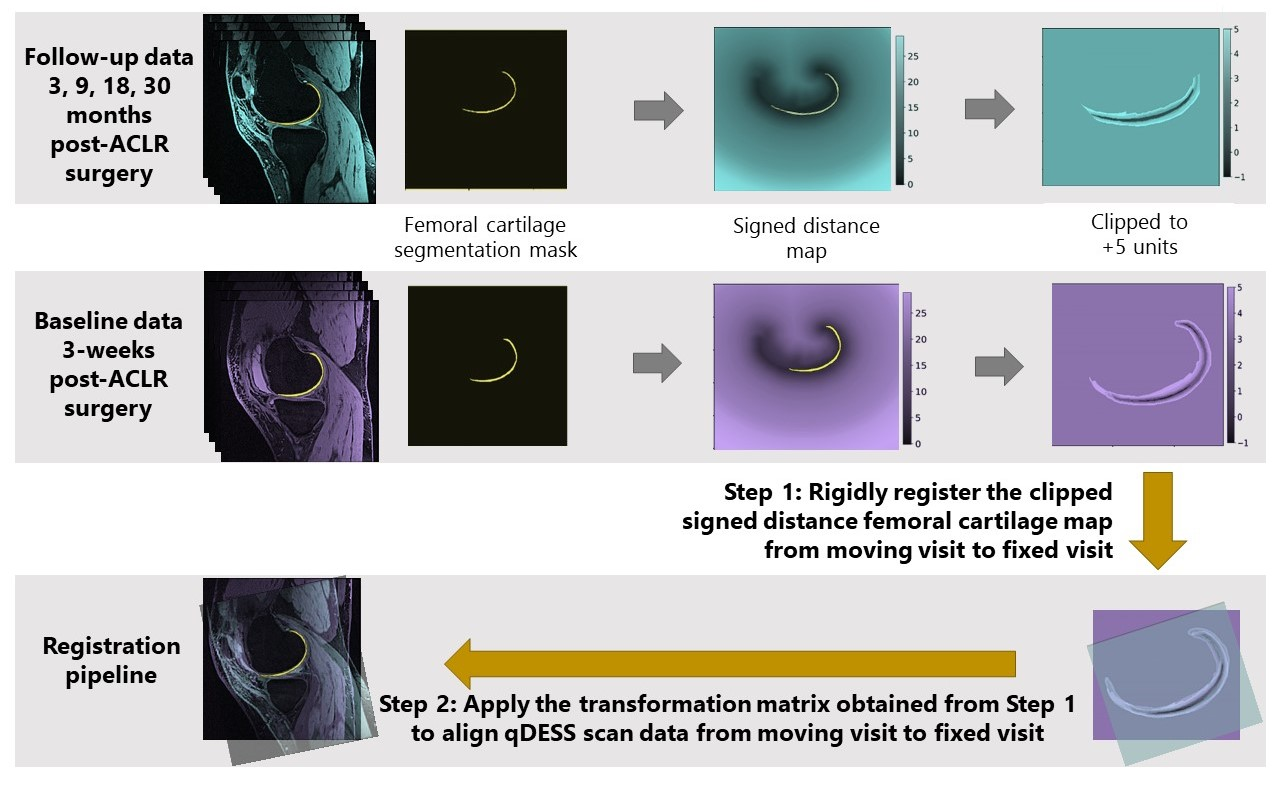

In [23]:
sgd_based_registration(
    fixed_img_path = baseline_qdess_path,
    moving_img_path = followup_qdess_path,
    moving_img_save_path = followup_qdess_reg_path,
    fixed_mask_path = baseline_mask_path,
    moving_mask_path = followup_mask_path,
    elastix_file_path = elastix_file_path,
    reg_check = True  # if True, it will save the a jpg pciture of a random slice (n) of the segmentation mask of the fixed image overlayed on the registered moving image)
    ) 

Registration already done between Base_A1 and Follow_B1


Starting Registration


100%|██████████| 1/1 [02:06<00:00, 126.43s/it]


Registration completed
Saving registered qmap files for Follow_B1


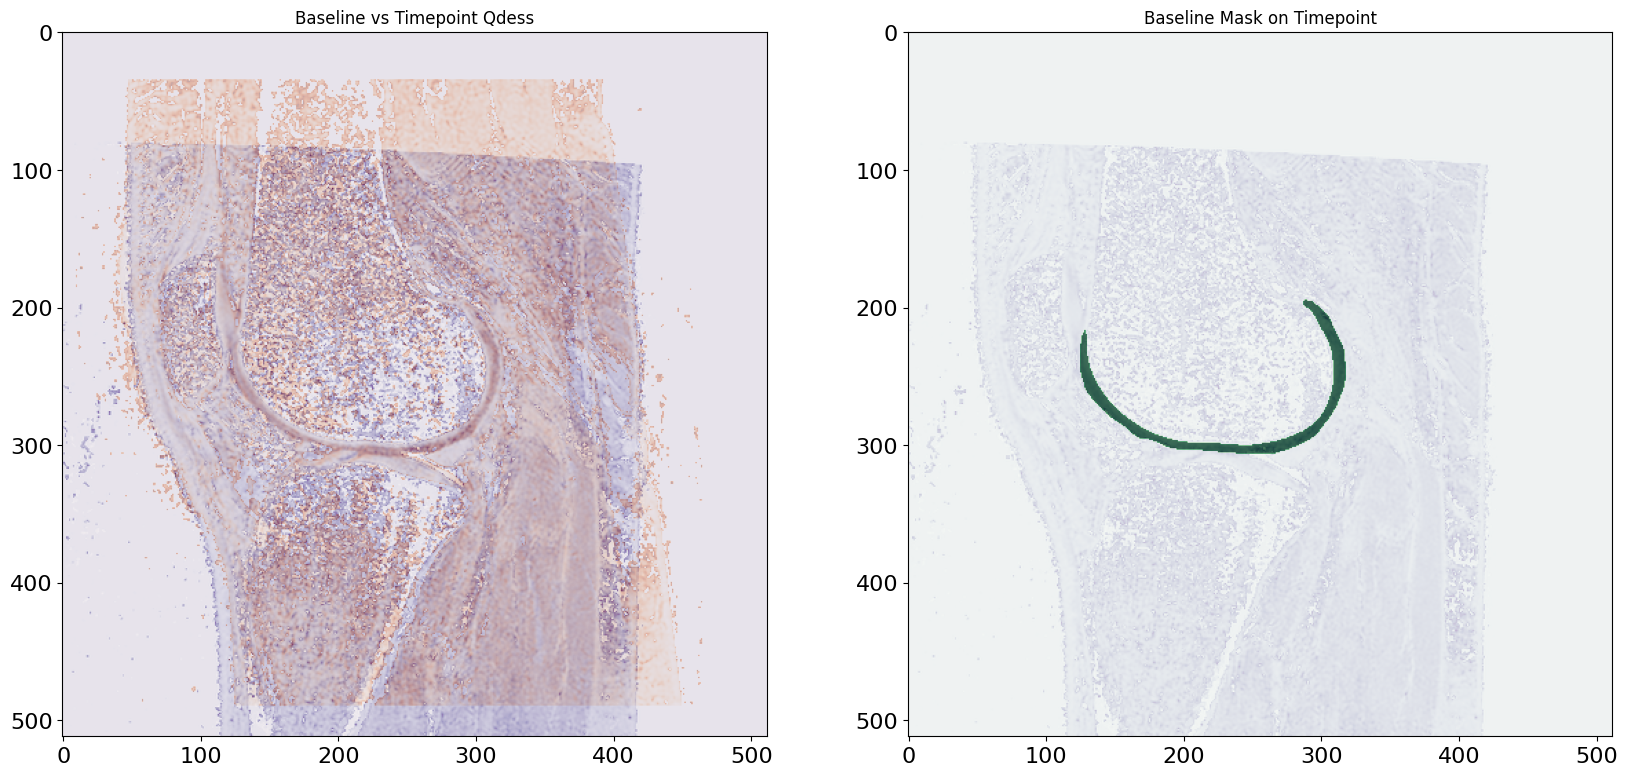

In [12]:
sgd_based_qmap_registration(
    fixed_img_path = baseline_qdess_path,
    moving_img_path = followup_qdess_path,
    moving_img_save_path = followup_qdess_reg_path,
    fixed_qmap_path = baseline_qmap_b1corr_path,
    moving_qmap_path = followup_qmap_b1corr_path,
    moving_qmap_save_path = followup_qmap_b1corr_reg_path,
    fixed_mask_path = baseline_mask_path,
    moving_mask_path = followup_mask_path,
    elastix_file_path = elastix_file_path,
    reg_check = True  # if True, it will save the a jpg pciture of a random slice (n) of the segmentation mask of the fixed image overlayed on the registered moving image)
    )

## C. Set segmentation mask (FC) after registration

Option 1: Use dosma to re-segment the FC mask (optional but recommeneded) on the registered moving image

Option 2: Use segmentation mask from the fixed image for all the following processing steps

In [11]:
# Option 1
dosma_segmentation(
    qdess_file_path = followup_qdess_reg_path,
    output_file_path = followup_mask_reg_path,
    weights_path = dosma_seg_weights_path
)

# Option 2
# followup_mask_reg_path = baseline_mask_path


2024-06-25 15:27:00.460903: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-25 15:27:00.460947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (torino): /proc/driver/nvidia/version does not exist
2024-06-25 15:27:00.468992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


8/8 [==============================] - 26s 3s/step


## D. Check goodness of the registration

To evaluate the quality of this registration pipeline, we recommened a two-fold assessment. 
1. First, performed a qualitative visual inspection of a randomly selected single slice for each registered pair (check the "/registration_check" directory). 
2. Re-segmented the femoral cartilage on the qDESS after registration using DOSMA (Step 1C option 1) and computed the Dice similarity coefficient compared to the originally segmented femoral cartilage mask from the fixed scan. Scan data with Dice < 0.75 are considered to be not good enough

In [13]:
# load masks

baseline_mask = nib.load(baseline_mask_path).get_fdata()
followup_mask_reg = nib.load(followup_mask_reg_path).get_fdata()

DSC= compute_DSC(
    mask1= baseline_mask,
    mask2= followup_mask_reg
)

if DSC < 0.75:
    print(f'Dice score is: {np.round(DSC, 4)}. Registration is not accurate. Please check the registration')
else:
    print(f'Dice score is: {np.round(DSC, 4)}. Registration is good')

Dice score is: 0.8643. Registration is good


# Step 2: Quantitative Maps

## A. Compute quantitative maps (T2/T1rho) of the tissue (Femoral cartilage in this case)

IMPORTANT: Change the lateral2medial or medial2lateral flag based on your data!

Computing T2 map...


/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mask * echo_2 / echo_1
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo_2 / echo_1
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: overflow encountered in true_divide
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: divide by zero encountered in log
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/tissues/femoral_cartilage.py:480: UserWarning: T2: Pixel value exceede

saved FC T2 data
Computing T2 map...


/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:217: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo_2 / echo_1
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/scan_sequences/mri/qdess.py:221: RuntimeWarning: divide by zero encountered in log
  t2map = -2000 * (TR - TE) / (xp.log(abs(ratio) / k) + c1)
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/tissues/femoral_cartilage.py:480: UserWarning: T2: Pixel value exceeded upper bound (80.0). Using normalized scale.
  warnings.warn(
/dataNAS/people/anoopai/miniconda3/envs/dess/lib/python3.9/site-packages/dosma/utils/io_utils.py:129: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()


saved FC T2 data


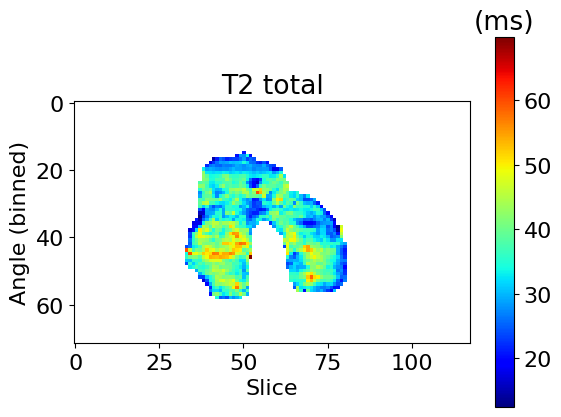

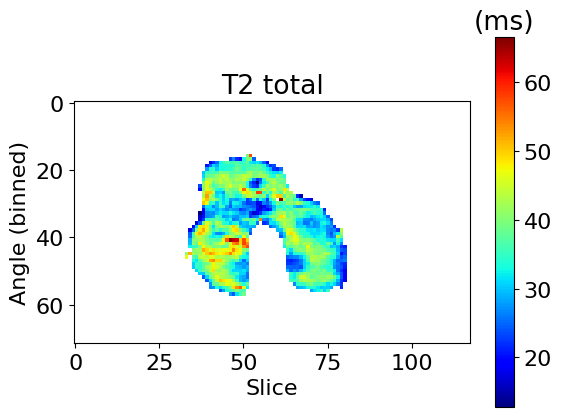

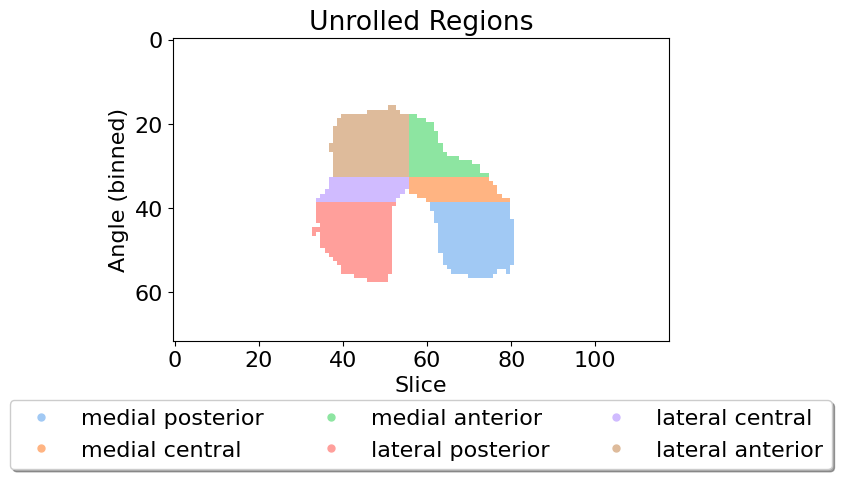

In [25]:
# baseline 
compute_t2(qdess_path = baseline_qdess_path,
           mask_path = baseline_mask_path,
           t2_save_path = baseline_qmap_path,
           lateral2medial = True)

# # followup before registration
# compute_t2(qdess_path = followup_qdess_path,
#            mask_path = followup_mask_path,
#            t2_save_path = followup_qmap_path,
#            lateral2medial = False)

# followup after registration
compute_t2(qdess_path = followup_qdess_reg_path,
           mask_path = followup_mask_reg_path,
           t2_save_path = followup_qmap_reg_path,
           lateral2medial = True)

## B.Filter the T2 maps

##### The FWHM  (in mm) is chosen such that, the kernel size is greater than the in-plane pixel spacing, but smaller than the thickness dimension of the tissue in sagittal plane (e.g., for FC and TC, thickness ~ 3-4mm in Humans)

In [26]:
#  Load qmap image
baseline_qmap = nib.load(baseline_t2_map_path)
followup_qmap = nib.load(followup_t2_map_reg_path)

# Filter qmaps
baseline_qmaps_filtered= filter_qmaps(baseline_qmap, fwhm= 1) # Check the fwhm value for your used-case!!!!
followup_qmaps_filtered= filter_qmaps(followup_qmap, fwhm= 1)

#save filtered qmaps
nib.save(baseline_qmaps_filtered, baseline_t2_map_filt_path)
nib.save(followup_qmaps_filtered, followup_t2_map_reg_filt_path)

With B1 Correction

In [15]:
#  Load qmap image
baseline_qmap = nib.load(baseline_qmap_b1corr_path)
followup_qmap = nib.load(followup_qmap_b1corr_reg_path)

# Filter qmaps
baseline_qmaps_filtered= filter_qmaps(baseline_qmap, fwhm= 1) # Check the fwhm value for your used-case!!!!
followup_qmaps_filtered= filter_qmaps(followup_qmap, fwhm= 1)

#save filtered qmaps
nib.save(baseline_qmaps_filtered, baseline_t2_map_b1corr_filt_path)
nib.save(followup_qmaps_filtered, followup_t2_map_b1corr_reg_filt_path)

Check if the filtering has worked/ looks fine

(-0.5, 511.5, 511.5, -0.5)

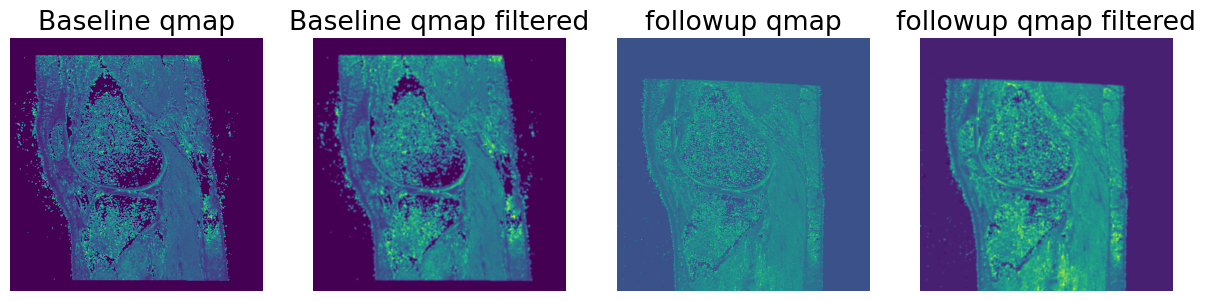

In [16]:
n=40

fig1, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
ax[0].imshow(baseline_qmap.get_fdata()[:,:,n])
ax[0].set_title('Baseline qmap')
ax[0].axis('off')

ax[1].imshow(baseline_qmaps_filtered.get_fdata()[:,:,n])
ax[1].set_title('Baseline qmap filtered')
ax[1].axis('off')

ax[2].imshow(followup_qmap.get_fdata()[:,:,n])
ax[2].set_title('followup qmap')
ax[2].axis('off')

ax[3].imshow(followup_qmaps_filtered.get_fdata()[:,:,n])
ax[3].set_title('followup qmap filtered')
ax[3].axis('off')

# Step 3: Cluster Analysis

Cluster analysis requires calculation of T2 difference maps between the timepoints, and two thresholding steps to identify prominent regions of elevated T2

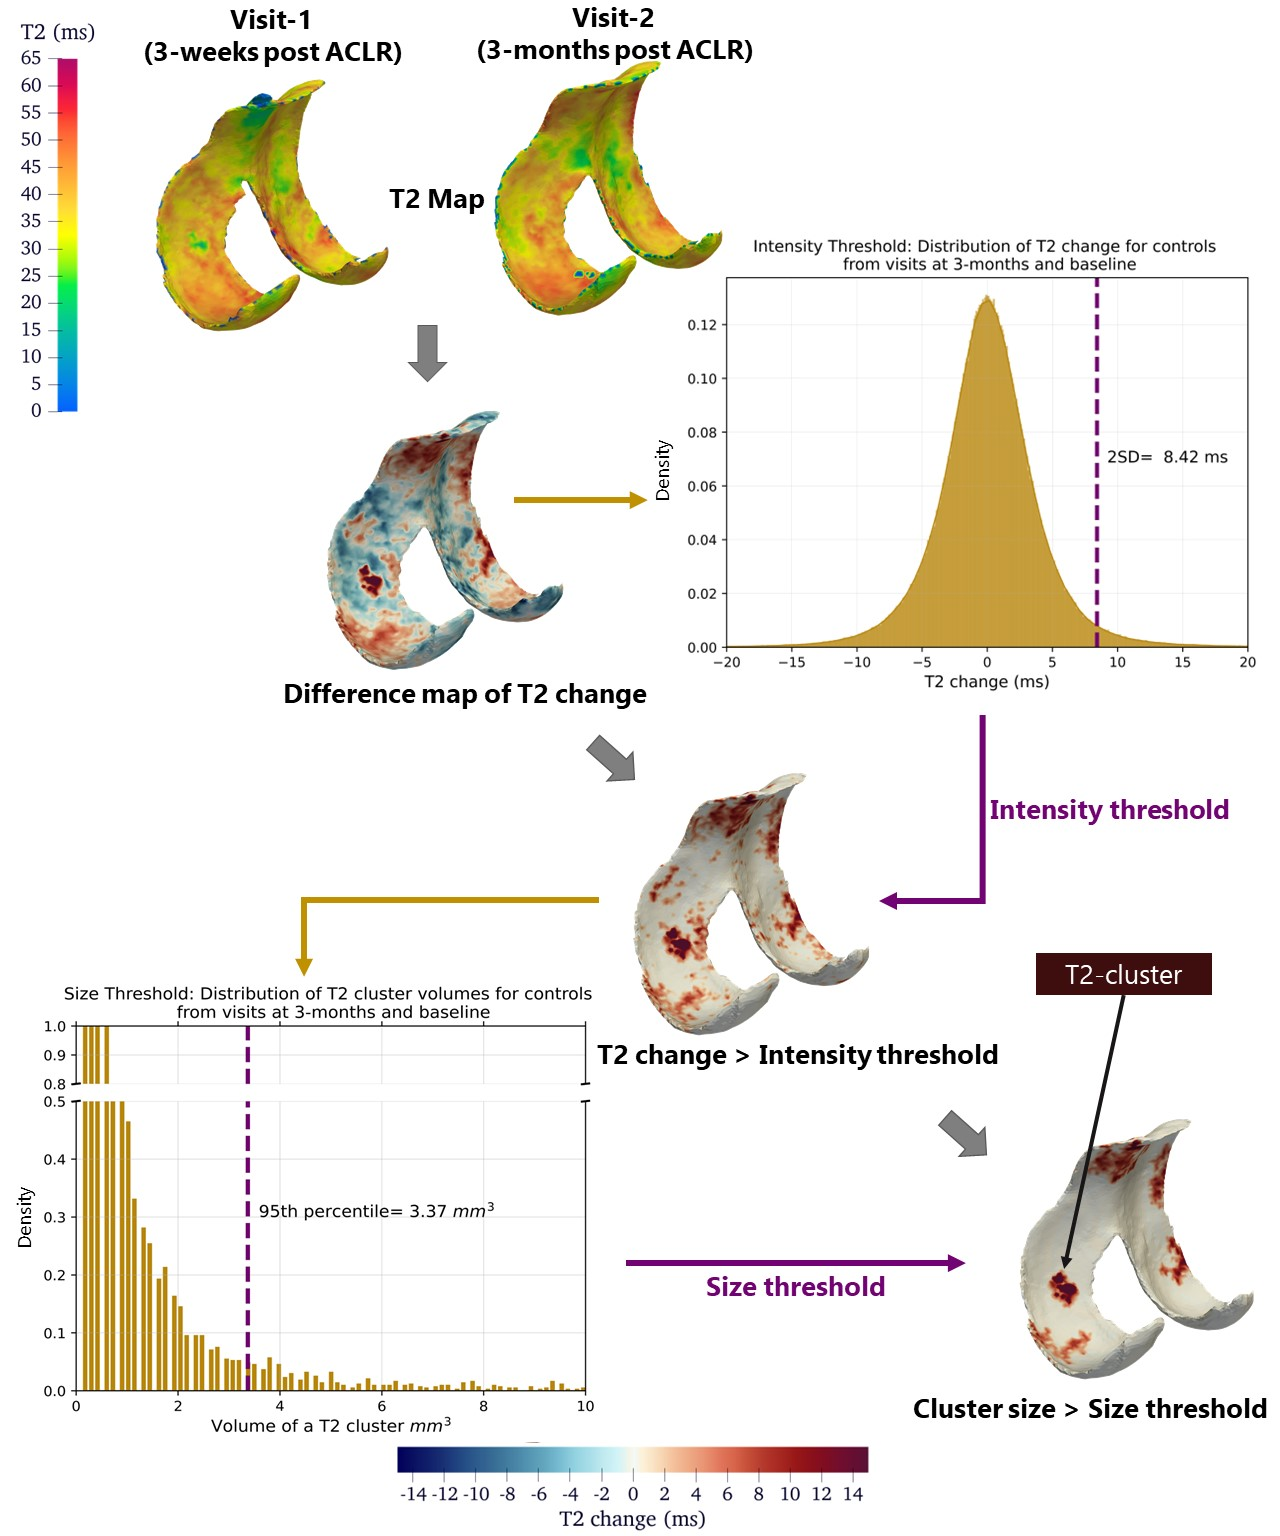

## A. Compute difference maps

In [28]:
# Load segmentation masks
baseline_mask = nib.load(baseline_mask_path)
followup_mask_reg = nib.load(followup_mask_reg_path)
baseline_qmaps_filtered = nib.load(baseline_t2_map_filt_path)
followup_qmaps_filtered = nib.load(followup_t2_map_reg_filt_path)

baseline_qmaps_filtered = nib.load(baseline_t2_map_b1corr_filt_path)
followup_qmaps_filtered = nib.load(followup_t2_map_b1corr_reg_filt_path)

In [17]:
# Load segmentation masks
baseline_mask = nib.load(baseline_mask_path)
followup_mask_reg = nib.load(followup_mask_reg_path)
baseline_qmaps_filtered = nib.load(baseline_t2_map_b1corr_filt_path)
followup_qmaps_filtered = nib.load(followup_t2_map_b1corr_reg_filt_path)

In [18]:
# compute difference map
difference_map = difference_map_tissue(
    baseline_qmap= baseline_qmaps_filtered, 
    followup_qmap= followup_qmaps_filtered, 
    baseline_mask=baseline_mask, 
    followup_mask= followup_mask_reg, 
    mask_erode= True, 
    erode_size= 1)

# Save difference map
nib.save(difference_map, difference_map_save_path)

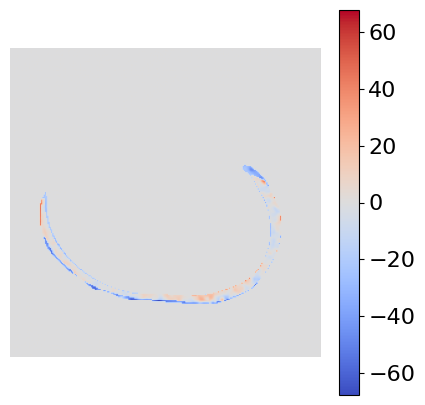

In [19]:
# Plot and check
n=45

data = difference_map.get_fdata()[100:350,100:350,n]
vmin = -np.abs(data).max()
vmax = np.abs(data).max()
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(data, cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.colorbar()

## B. Intensity Thresholding

##### We compute the intensity threshold from our control population. 

Option 1: Create a 4D NumPy array containing the 3D difference maps (axes 0-2) for all subjects (axis 3). 
    
    - For example you may have a (512, 512, 80, 10) array where (512, 512) is the in-plane image size, 80 is number of out-of-plane MR slices and 10 is the number of subjects

Option 2: You can also use the default value (as calculated from my data: control data difference maps of Visit at 3-months and visit-1 at 3-weeks pst ACLR). 

    - Intensity Value = 8.42 ms

### B i) Compute Intensity threshold

       Mean     2*Std
0  0.053055  8.421445


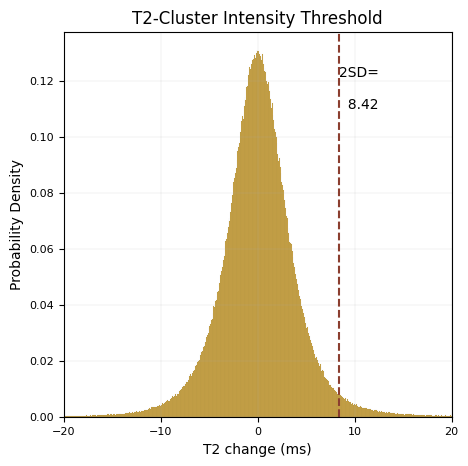

In [18]:
# Load a 4D array of difference maps where 
with open(differene_maps_all_path, 'rb') as file:
    differene_maps_all = pickle.load(file)
    
# Compyte intensity threshold
compute_intensity_threshold(
    difference_maps_all = differene_maps_all,
    std_values= [1, 2, 3]   # Specifiy all the values at which you want to compute the threshold
)

### B ii) Apply intensity threshold to difference map

In [20]:
difference_map = nib.load(difference_map_save_path)

# Apply intensity threshold
diff_map_intensity_thresholded = apply_intensity_threshold(
    difference_map=difference_map, 
    intensity_threshold= 8.42,  # change this!
    cluster_type='pos')

# save intensity thresholded difference map
nib.save(diff_map_intensity_thresholded, diff_map_intensity_thresholded_save_path)

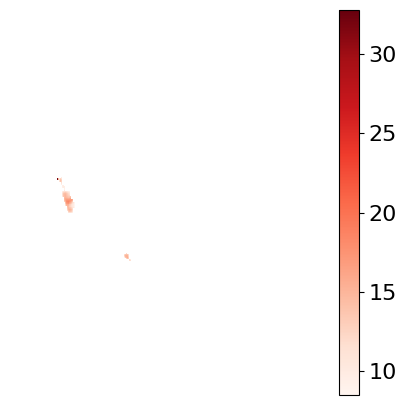

In [21]:
# Plot and check
n=55
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(diff_map_intensity_thresholded.get_fdata()[200:300,100:300,n], cmap='Reds')
plt.axis('off')
plt.colorbar()

## C Volume Threshold 

##### We compute the volume threshold from our control population. 

Option 1: Create a 4D NumPy array containing the intensity thresholded 3D difference maps (axes 0-2) for all subjects (axis 3). 
    
    - For example you may have a (512, 512, 80, 10) array where (512, 512) is the in-plane image size, 80 is number of out-of-plane MR slices and 10 is the number of subjects

Option 2: You can also use the default value (as calculated from my data: control data difference maps of Visit at 3-months and visit-1 at 3-weeks pst ACLR). 

    - Volume threshold Value = 23 voxels

Currently the volume threshold is measured in terms of number of voxels

### B i) Compute Volume threshold

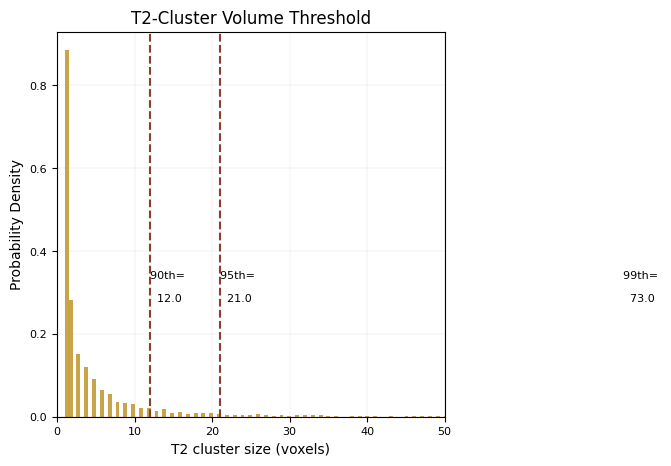

   Percentile  Volume Threshold
0          90              12.0
1          95              21.0
2          99              73.0


In [19]:
# Load a 4D array of difference maps where 
with open(diff_map_intensity_thresholded_all_path, 'rb') as file:
    difference_maps_int_all = pickle.load(file)
    
# Compyte intensity threshold
compute_volume_threshold(
    difference_maps_int_all = difference_maps_int_all,
    percentile_values= [90, 95, 99]   # Specifiy all the percentile values at which you want to compute the threshold
)

### C ii) Apply Volume threshold to intensity-thresholded difference map

In [22]:
# Load intensity thresholded difference map
diff_map_intensity_thresholded = nib.load(diff_map_intensity_thresholded_save_path)

# Apply volume threshold
difference_map_volume_thresholded = apply_volume_threshold(
    difference_map=diff_map_intensity_thresholded, 
    volume_threshold= 21) # change this!

# save intensity thresholded difference map
nib.save(difference_map_volume_thresholded, diff_map_volume_thresholded_save_path)

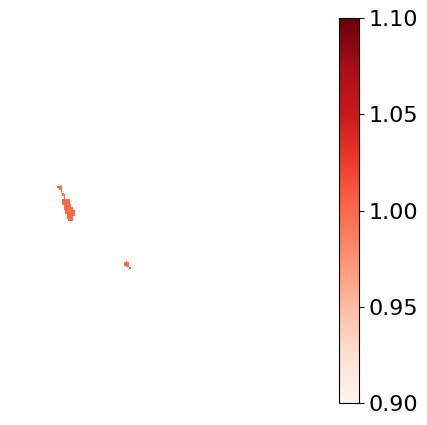

In [23]:
# Plot and check
n=55
fig1, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.imshow(difference_map_volume_thresholded.get_fdata()[200:300,100:300,n], cmap='Reds')
plt.axis('off')
plt.colorbar()

In [24]:
np.unique(difference_map_volume_thresholded.get_fdata())

array([ 1., nan])